In [68]:
#install unzip in notebook
!sudo apt-get install -y unzip zip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unzip zip
0 upgraded, 2 newly installed, 0 to remove and 50 not upgraded.
Need to get 335 kB of archives.
After this operation, 1231 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 unzip amd64 6.0-25ubuntu1.1 [168 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 zip amd64 3.0-11build1 [167 kB]
Fetched 335 kB in 0s (2045 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 25583 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-25ubuntu1.1_amd64.deb ...
Unpacking unzip (6.0-25ubuntu1.1) ...
Selecting previously unselected package zip.
Preparing to unpack .../zip_3.0-11build1_amd64.deb ...
Unpacking zip (3.0-11build1) ...
Setting up unzip (6.0-25ubuntu1.1) 

In [69]:
!pip install boto3 datasets


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [70]:
import boto3

s3 = boto3.resource('s3', endpoint_url='https://storage.s3.mlops.wogra.com')
bucket = s3.Bucket('data')

In [71]:
bucket.download_file('dlr/dataset_tapelegen.zip', 'data.zip')

In [72]:
# extreact zip file to data folder
!rm -r data
!unzip data.zip -d data

Archive:  data.zip
   creating: data/dataset_tapelegen/
  inflating: data/dataset_tapelegen/dataset_info.json  
  inflating: data/dataset_tapelegen/data-00001-of-00003.arrow  
  inflating: data/dataset_tapelegen/state.json  
  inflating: data/dataset_tapelegen/data-00000-of-00003.arrow  
  inflating: data/dataset_tapelegen/data-00002-of-00003.arrow  
 extracting: data/dataset_tapelegen/dataset_dict.json  
   creating: data/dataset_tapelegen/train/
  inflating: data/dataset_tapelegen/train/dataset_info.json  
  inflating: data/dataset_tapelegen/train/data-00001-of-00003.arrow  
  inflating: data/dataset_tapelegen/train/state.json  
  inflating: data/dataset_tapelegen/train/data-00000-of-00003.arrow  
  inflating: data/dataset_tapelegen/train/data-00002-of-00003.arrow  


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 11.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.0/39.0 MB 47.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 7.0.0
    Uninstalling pyarrow-7.0.0:
      Successfully uninstalled pyarrow-7.0.0

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# create a dataset for images in the folders and use the folder name as label
from datasets import load_from_disk

dataset = load_from_disk("data/dataset_tapelegen/")

# take random seed of examples from dataset
dataset = dataset.shuffle(seed=42)
dataset


/home/ray/anaconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['image', 'label'],
    num_rows: 73749
})

In [3]:
# remove all items from dataset with mean 0 but dont use remove rows which not exists as method
import numpy as np
clean_dataset = dataset.filter(lambda example: np.mean(example["image"]) != 0)

In [5]:
clean_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 72287
})

In [7]:
!pip install transformers==4.26.1 evaluate


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [8]:
import transformers

checkpoint = "google/vit-base-patch16-224-in21k"

feature_extractor = transformers.AutoFeatureExtractor.from_pretrained(
    checkpoint
)
print(feature_extractor.size)
print(feature_extractor.image_mean)
print(feature_extractor.image_std)

{'height': 224, 'width': 224}
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]


In [10]:
from torchvision import transforms
import numpy as np

def preprocess(image):
    # convert image to tensor
    tensor = transforms.ToTensor()(image)
    tensor = tensor - np.mean(tensor.numpy()) + 128
    tensor[tensor < 0] = 0
    tensor[tensor > 255] = 255
    tensor = tensor / 255
    # repeat the tensor two ore times to get 3 channels and use the repeat function
    tensor = tensor.repeat(3, 1, 1)
    return tensor


class Preprocess:
    def __init__(self):
        self.transforms = transforms.Compose(
            [
                transforms.Lambda(preprocess),
                transforms.CenterCrop(224),
            ]
        )

    def __call__(self, example_batch):
        example_batch["pixel_values"] = [
            self.transforms(img) for img in example_batch["image"]
        ]
        del example_batch["image"]
        return example_batch
    
preprocessed_dataset = clean_dataset.with_transform(Preprocess())

In [11]:
labels = clean_dataset.features["label"].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [12]:

from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:

from transformers import TrainingArguments

batch_size = 14*16

training_args = TrainingArguments(
    output_dir="my_tapelegen_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)


In [14]:
import evaluate
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

accuracy = evaluate.load("accuracy")

import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [15]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [23]:
# 90% train, 10% test + validation
split_one = preprocessed_dataset.train_test_split(test_size=0.8)

In [26]:
# Split the 10% test + valid in half test, half valid
split_two = split_one['test'].train_test_split(test_size=0.95)

In [27]:
from datasets import DatasetDict

train_test_valid_dataset = DatasetDict({
    "train": split_one["train"],
    "validate": split_two["train"],
    "test": split_two["test"]})
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14457
    })
    validate: Dataset({
        features: ['image', 'label'],
        num_rows: 2891
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 54939
    })
})

In [28]:
model.to('cuda')

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [31]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_test_valid_dataset["train"],
    eval_dataset=train_test_valid_dataset["validate"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [32]:
trainer.train()

/home/ray/anaconda3/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14457
  Num Epochs = 3
  Instantaneous batch size per device = 224
  Total train batch size (w. parallel, distributed & accumulation) = 2688
  Gradient Accumulation steps = 4
  Total optimization steps = 15
  Number of trainable parameters = 85800963
/home/ray/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 2891
  Batch size = 672
  Num examples = 2891
  Batch size = 672
Saving model checkpoint to my_tapelegen_model/checkpoint-5
Configuration saved in my_tapelegen_model/checkpoint-5/config.json
Saving model checkpoint to my_tapelegen_model/checkpoint-5
Configuration saved in my_tapelegen_model/checkpoint-5/config.json
Model weights saved in my_tapelegen_model/checkpoint-5/pytorch_model.bin
Image processor saved in my_tapelegen_model/checkpoint-5/preprocessor_config.json
/home/ray/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 2891
  Batch size = 672
Saving model checkpoint to my_tapelegen_model/checkpoint-10
Configuration saved in my_tapelegen_model/checkpoint-10/config.jso

TrainOutput(global_step=15, training_loss=0.6555174509684245, metrics={'train_runtime': 209.724, 'train_samples_per_second': 206.8, 'train_steps_per_second': 0.072, 'total_flos': 3.2821251445223055e+18, 'train_loss': 0.6555174509684245, 'epoch': 2.91})

In [36]:
trainer.state.log_history

[{'eval_loss': 0.6240933537483215,
  'eval_accuracy': 0.8408855067450709,
  'eval_runtime': 8.1299,
  'eval_samples_per_second': 355.603,
  'eval_steps_per_second': 0.615,
  'epoch': 0.91,
  'step': 5},
 {'loss': 0.7582,
  'learning_rate': 1.923076923076923e-05,
  'epoch': 1.91,
  'step': 10},
 {'eval_loss': 0.42211490869522095,
  'eval_accuracy': 0.8408855067450709,
  'eval_runtime': 8.1076,
  'eval_samples_per_second': 356.579,
  'eval_steps_per_second': 0.617,
  'epoch': 1.91,
  'step': 10},
 {'eval_loss': 0.37300825119018555,
  'eval_accuracy': 0.8433068142511242,
  'eval_runtime': 8.1097,
  'eval_samples_per_second': 356.488,
  'eval_steps_per_second': 0.617,
  'epoch': 2.91,
  'step': 15},
 {'train_runtime': 209.724,
  'train_samples_per_second': 206.8,
  'train_steps_per_second': 0.072,
  'total_flos': 3.2821251445223055e+18,
  'train_loss': 0.6555174509684245,
  'epoch': 2.91,
  'step': 15}]

In [58]:
# iterate over the log history and collect the value eval_loss in a list if the key exists in the dict item
eval_loss = [item["eval_loss"] for item in trainer.state.log_history if "eval_loss" in item.keys()]

In [60]:
# now collect the accuracy in a list ehich has the key eval_accuracy
eval_accuracy = [item["eval_accuracy"] for item in trainer.state.log_history if "eval_accuracy" in item.keys()]

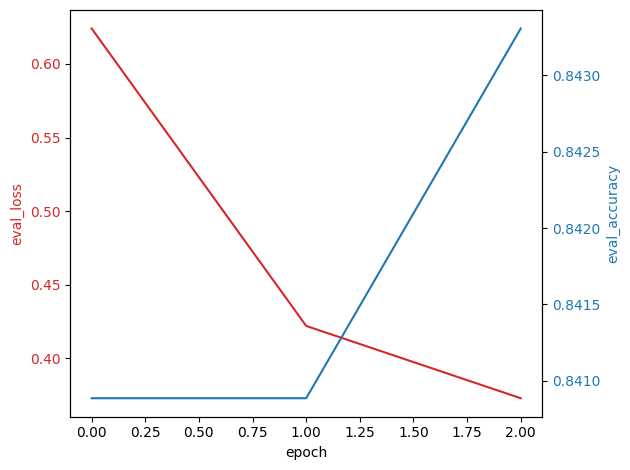

In [61]:
# plot eval loss and accuracy in the same plot with two y axis

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('eval_loss', color=color)
ax1.plot(eval_loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('eval_accuracy', color=color)
ax2.plot(eval_accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()
